In [1]:
# 导入所需模块
import pandas as pd
import numpy as np
import json
import fp_growth_py3 as fpg
import matplotlib.pyplot as plt
import pylab as pl
from collections import defaultdict


In [2]:
def evaluate_association_rules(rules_to_evaluate,test_datas):
    """
    Parameters：
        rules_to_evaluate：要评估的关联规则（推荐规则） list((rule_a,rule_b))
        test_datas：测试用的数据集 dataframe

    Returns：
        关联规则（推荐规则）在测试集上的平均准确率
    """
    point_sum = 0
    miss = 0
    for rule_a,rule_b in rules_to_evaluate:
        set_rule_a = set(rule_a)
        set_rule_b = set(rule_b)  
        
        num_a = 0
        num_b = 0
        
        for test_data in test_datas.value:
            set_test_data = set(test_data)
            if set_rule_a.issubset(set_test_data):
                num_a += 1
                if set_rule_b.issubset(set_test_data):
                    num_b += 1
        if num_a:
            point_sum += num_b / num_a
        else:
            miss += 1
#     print(miss,' rules miss')
    return point_sum / len(rules_to_evaluate)
    

In [3]:
# 读入测试数据集
filepath='./test_data/user_following_animation.json'
data=pd.read_json(filepath,lines=True)
user_info = pd.read_csv("test_data/bilibili_crawler_user_info.csv",names = ['id','mid','name','sex','sign','the_rank','level','jointime','moral','silence','birthday','coins','fans_badge','role','title','desc','vip_type','vip_status'])

user_info.drop(user_info[user_info.vip_type.isna() | user_info.the_rank.isna() | user_info.level.isna()].index.tolist(),inplace=True) # 将vip_type、the_rank、level有NaN的行去掉


In [4]:
add_rules={'the_rank':{10000:1,20000:2,25000:3,30000:4},'level':{'3':1,'4':2,'5':3,'6':4},'vip_type':{0:0,1:1,2:2}}


In [5]:
for index,row in data.iterrows():
    try:
        int(row.key)
    except:
        print(row)
        data.drop(index,inplace=True)

db                                                       7
key                                         finished_users
size                                                507576
ttl                                                     -1
type                                                   set
value    [330817737, 74775, 259640193, 24774761, 540994...
Name: 4504, dtype: object


In [6]:
def user_power(data,rules,user_info):
    """
    params:
        data:用户收藏ID数据集
        rules:权重规则
        user_info:用户信息数据集
    return:新数据集
        
    """
    new_data = pd.DataFrame(columns=data.columns)
    for index,row in data.iterrows():
        info = user_info[user_info.mid == int(row.key)]

        if len(info):
            the_power = rules['the_rank'][info.the_rank.values[0]] + rules['level'][info.level.values[0]] + rules['vip_type'][info.vip_type.values[0]]
        else:  # len(info)==0 说明在user_info中没有这个用户的相关数据
            the_power = 1
#         print(the_power)
        for i in range(the_power):
            new_data = new_data.append(row,ignore_index=True)
    return new_data

In [7]:
new_data= user_power(data,add_rules,user_info)
training_data = new_data.sample(n=None, frac=0.9, replace=False, weights=None, random_state=None, axis=None)
evaluate_data = new_data.drop([x for x in training_data.index])


In [8]:

data_list = list(training_data["value"])
frequent_itemsets = fpg.find_frequent_itemsets(data_list, minimum_support=0.07 * len(data_list), include_support=True)
print(type(frequent_itemsets))  # print type
result = []
for itemset, support in frequent_itemsets:  # 将generator结果存入list
    result.append((itemset, support / len(data_list)))

result_patterns = [i[0] for i in result]
result_support = [i[1] for i in result]
patterns_df = pd.DataFrame({"fluent_patterns": result_patterns, "support": result_support})
patterns = {}
for i in result:
    patterns[frozenset(sorted(i[0]))] = i[1]
print("-------------挖掘频繁项集---------------")
print(patterns_df)

def generate_rules(patterns, min_confidence):
    patterns_group = group_patterns_by_length(patterns)
    raw_rules = defaultdict(set)
    for length, pattern_list in patterns_group.items():
        if length == 1:
            continue
        for pattern, support in pattern_list:
            item_list = list(pattern)
            for window_size in range(1, length):
                for i in range(0, length - window_size):
                    for j in range(i + window_size, length):
                        base_set = frozenset(item_list[i:j])
                        predict_set = frozenset(pattern - base_set)
                        confidence = support / patterns.get(base_set)
                        if confidence > min_confidence:
                            raw_rules[base_set].add((predict_set, confidence))

                        base_set, predict_set = predict_set, base_set
                        confidence = support / patterns.get(base_set)
                        if confidence > min_confidence:
                            raw_rules[base_set].add((predict_set, confidence))
    return raw_rules

def group_patterns_by_length(patterns):
    result = defaultdict(list)
    for pattern, support in patterns.items():
        result[len(pattern)].append((pattern, support))
    return result

def transform(raw_rules):
    result = list()
    for base_set, predict_set_list in raw_rules.items():
        for predict_set, confidence in predict_set_list:
            result.append((base_set, predict_set, confidence))

    return result
raw_rules = generate_rules(patterns, 0.6)
rules = transform(raw_rules)
rules.sort(key=lambda x: x[2], reverse=True)
rules_a = [i[0] for i in rules]
rules_b = [i[1] for i in rules]
confidence = [i[2] for i in rules]
rules_df = pd.DataFrame({"rules_a": rules_a, "rules_b": rules_b, "confidence": confidence})
print(rules_df)

<class 'generator'>
-------------挖掘频繁项集---------------
                     fluent_patterns   support
0                             [8892]  0.305872
1                     [102392, 8892]  0.160676
2                          [5267730]  0.299433
3                    [8892, 5267730]  0.167916
4            [102392, 8892, 5267730]  0.099325
5                  [102392, 5267730]  0.155268
6                  [139252, 5267730]  0.191381
7          [102392, 139252, 5267730]  0.106021
8            [8892, 139252, 5267730]  0.122589
9    [102392, 8892, 139252, 5267730]  0.075001
10                            [8792]  0.201024
11                      [8892, 8792]  0.121931
12              [102392, 8892, 8792]  0.073714
13                   [5267730, 8792]  0.105649
14             [8892, 5267730, 8792]  0.075230
15           [139252, 5267730, 8792]  0.085818
16                    [139252, 8792]  0.126881
17              [8892, 139252, 8792]  0.084616
18            [102392, 139252, 8792]  0.079179
19   

In [9]:
import association_rules
animation = pd.read_json("./test_data/bilibili_crawler_animation.json", encoding="utf-8")
animation["score"] = animation["score"].fillna('%.1f' % animation["score"].mean())
animation[["follow", "play"]] = animation[["follow", "play"]].applymap(association_rules.trans)
animation_feature = pd.read_json("./test_data/bilibili_crawler_animation_feature.json",dtype={"character_voice_list": str})
animation_feature[["tag_list", "character_voice_list", "character_staff_list"]] = animation_feature[["tag_list", "character_voice_list", "character_staff_list"]].applymap(json.loads)

# #将关联规则的后项展开
rules_df = association_rules.unfold_rules(rules_df)


In [121]:
def find_good_para(rules,animation, animation_feature,confidence=0.5,score=0.1,play=0.1,follow=0.1,voice=0.1,staff=0.1):
    rules_weight = {"confidence": confidence, "score": score, "play": play, "follow": follow, "voice": voice, "staff": staff}
    rules_df = association_rules.add_score(rules, rules_weight, animation, animation_feature)
    rules_df.sort_values(by='score',inplace=True,ascending=False)
    
    new_rule = []
    for index,row in rules_df.iterrows():
        b=[]
        for item in row[0]:
            b.append(str(item))
        new_rule.append([b,[str(row[1])]])
    
    print(rules_weight)
    print('\t000-100 : ',evaluate_association_rules(new_rule[:100],evaluate_data))
    return (new_rule,rules_df)
#     print('\t100-200 : ',evaluate_association_rules(new_rule[100:200],evaluate_data))
#     print('\t200-300 : ',evaluate_association_rules(new_rule[200:300],evaluate_data))
#     print('\tall_data: ',evaluate_association_rules(new_rule,evaluate_data))

In [122]:
config = {
    "confidence": 0.5, 
    "score": 0.1, 
    "play": 0.1, 
    "follow": 0.1, 
    "voice": 0.1, 
    "staff": 0.1
}


final_rule,final_rule_df = find_good_para(rules_df,animation, animation_feature,**config)


{'confidence': 0.5, 'score': 0.1, 'play': 0.1, 'follow': 0.1, 'voice': 0.1, 'staff': 0.1}
	000-100 :  0.8487168770598393


In [12]:
def recommend(rules,user_data):
    """
    Params:
        rules:推荐规则    格式：[[rules_a][rules_b]]
        user_data:用户收藏信息  格式：Dataframe 包含value
        
    Returns:
        推荐影片ID列表（10个以内）
    """
    recommend_list = []
    for rule_a,rule_b in rules:
        rule_a_set = set(rule_a)
        user_data_set = set(user_data.value) 

        if rule_a_set.issubset(user_data_set):
            if rule_b[0] not in recommend_list: # rule_b都是只有一个影片，所以用rule_b[0]提取出来就行
                recommend_list.append(rule_b[0])           
    return recommend_list[:10]

In [13]:
training_data.iloc[0]

db                                                       7
key                                               69233250
size                                                    67
ttl                                                     -1
type                                                   set
value    [6352, 6360, 6434, 8772, 8792, 8892, 8992, 234...
Name: 3203, dtype: object

In [123]:
recommend(final_rule,training_data.iloc[0])

['139252',
 '8792',
 '102392',
 '102252',
 '8892',
 '5267730',
 '130412',
 '4316382',
 '6301']

In [124]:
len(final_rule)

688

In [16]:
len(training_data)

34946

In [17]:
len(evaluate_data)

3883

In [18]:
len(new_data)

38829

In [19]:
def get_support(rule,data):
    set_a = set(rule[0])
    set_b = set(rule[1])
    count = 0
    
    for index,row in data.iterrows():
        set_row = set(row.value)
        if set_a.issubset(set_row) or set_b.issubset(set_row):
            count +=1 
    return count/len(data)

In [20]:
def get_confidence(rule,data):
    set_a = set(rule[0])
    set_b = set(rule[1])
    
    num_x = 0
    num_xy = 0
    for index,row in data.iterrows():
        set_row = set(row.value)
        if set_a.issubset(set_row):
            num_x += 1
            if set_b.issubset(set_row):
                num_xy+=1
    return num_xy/num_x
    

In [21]:
get_support(final_rule[0],evaluate_data)

0.1529745042492918

In [22]:
get_confidence(final_rule[0],evaluate_data)

0.8636363636363636

In [23]:
def get_lift(rule,data):
    set_a = set(rule[0])
    set_b = set(rule[1])
    
    num_x = 0
    num_y = 0
    num_xy = 0
    for index,row in data.iterrows():
        set_row = set(row.value)
        if set_a.issubset(set_row):
            num_x += 1
            if set_b.issubset(set_row):
                num_xy+=1
        if set_b.issubset(set_row):
            num_y +=1
    confi = num_xy/num_x
    l = len(data)
    return confi/num_y*l
    

In [24]:
get_lift(final_rule[0],evaluate_data)

6.2101851851851855

In [25]:
def all_max_conf_kulc_cosine(rule,data):
    set_x = set(rule[0])
    set_y = set(rule[1])
    
    num_x = 0
    num_y = 0
    num_xy = 0
    p_x_y = 0
    p_y_x = 0
    for index,row in data.iterrows():
        set_row = set(row.value)
        if set_x.issubset(set_row):
            num_x += 1
            if set_y.issubset(set_row):
                num_xy+=1
        if set_y.issubset(set_row):
            num_y +=1
            
    p_x_y = num_xy / num_y
    p_y_x = num_xy / num_x
    
    
    return (min(p_x_y,p_y_x),max(p_x_y,p_y_x),(p_x_y+p_y_x)/2,pow((p_x_y*p_y_x),0.5))
    

In [26]:
print('all_conf,\t\tmax_conf,\t\tKulc,\t\t\tcosine')
for rule in final_rule[:10]:
    print(all_max_conf_kulc_cosine(rule,evaluate_data))

all_conf,		max_conf,		Kulc,			cosine
(0.6333333333333333, 0.8636363636363636, 0.7484848484848485, 0.7395739969534468)
(0.23432343234323433, 0.9250814332247557, 0.579702432783995, 0.46558378046300464)
(0.22937293729372937, 0.9055374592833876, 0.5674551982885585, 0.4557475034109693)
(0.2615511551155115, 0.9188405797101449, 0.5901958674128283, 0.4902283294447544)
(0.22524752475247525, 0.8950819672131147, 0.560164745982795, 0.44901558721867363)
(0.25495049504950495, 0.8956521739130435, 0.5753013344812743, 0.4778566365881045)
(0.2599009900990099, 0.8923512747875354, 0.5761261324432727, 0.48158382430620955)
(0.27887788778877887, 0.8941798941798942, 0.5865288909843365, 0.4993665989952499)
(0.23529411764705882, 0.8958990536277602, 0.5655965856374096, 0.4591293688321178)
(0.23860811930405965, 0.9056603773584906, 0.5721342483312751, 0.4648633340775699)


In [27]:
pow(4,0.5)


2.0

In [28]:
for rule in final_rule:
    print(get_lift(rule,evaluate_data))

6.2101851851851855
2.96377162146182
2.901156728050655
2.943777203807337
2.867659470865119
2.8694862964557326
2.858910891089109
2.8647694134492814
2.8821673779922063
2.913570211502087
2.8100759473537713
2.8729957600272917
2.7661635364567387
2.7947790632606537
2.85355670078965
2.7486113365434903
2.862723484984931
2.9086953908761926
2.7948002247033217
2.790402427339508
2.8159569601413303
2.706363991662324
2.8090584130046246
2.6438196828278815
2.735180532978671
2.791989172270862
2.749931336609504
2.7172591184619894
2.828800388538125
2.756141778561418
2.831395320668421
2.8883157251797607
2.7535322451164035
2.756448180752367
2.710903782685961
2.746110325318246
2.8055335229655562
2.8084126379901027
2.74702937161186
2.714326640997433
2.8362305037850337
2.754139887672978
2.6742424242424243
2.629981281710261
2.8310190555095276
2.6393961935053607
2.7145752284725684
2.8391056722850765
2.6454196133899104
2.6667429748755223
2.741443223904364
2.710903782685961
2.6186710736941956
2.6933005113698183
2.

In [29]:
set(final_rule[0][1])

{'1586'}

In [30]:
training_data.iloc[0].value

['6352',
 '6360',
 '6434',
 '8772',
 '8792',
 '8892',
 '8992',
 '23432',
 '25732',
 '33512',
 '78512',
 '102252',
 '102512',
 '5267730']

In [126]:
rules_sortedby_confidence=df.Data
rules_sortedby_confidence

,rules_a,rules_b,confidence
0,"(4316482, 4316382, 130412, 5267730)",(139252),0.917695
1,"(130412, 4316482, 4316382, 139252)",(5267730),0.915640
2,"(4316482, 134912, 5267730)",(139252),0.914097
3,"(139252, 4316382, 4762754)",(5267730),0.913249
4,"(4316382, 4316442)",(5267730),0.903540
5,"(4316482, 4316382, 139252)",(5267730),0.900264
6,"(4316482, 4316382, 130412)",(139252),0.900202
7,"(4316382, 21986963)",(5267730),0.899148
8,"(4316482, 4316382, 130412)",(5267730),0.898185
9,"(4316482, 130412, 134912)",(139252),0.897855


In [189]:
rules_sortedby_score=pd.DataFrame(columns=final_rule_df.columns)

for index,row in final_rule_df.iloc[:20].iterrows():
    rules_sortedby_score= rules_sortedby_score.append(row,ignore_index=True)
     

In [190]:
rules_sortedby_score

,rules_a,rules_b,confidence,score
0,{1587},1586,0.863447,1.624984
1,"{4316482, 5267730, 130412, 4316382}",139252,0.917695,1.575812
2,"{134912, 4316482, 5267730}",139252,0.914097,1.574013
3,"{4316482, 130412, 4316382}",139252,0.900202,1.567065
4,"{134912, 4316482, 130412}",139252,0.897855,1.565892
5,"{4316482, 8892, 130412}",139252,0.896481,1.565205
6,"{4316482, 5267730, 8892}",139252,0.891927,1.562928
7,"{4316482, 5267730, 130412}",139252,0.889853,1.561891
8,"{130412, 4316482, 139252, 4316382}",5267730,0.915640,1.558741
9,"{4762754, 139252, 4316382}",5267730,0.913249,1.557545


In [193]:
def get_animation_title(media_id):
    for index,row in animation.iterrows():
        if int(media_id)==row['media_id']:
            return row['title']

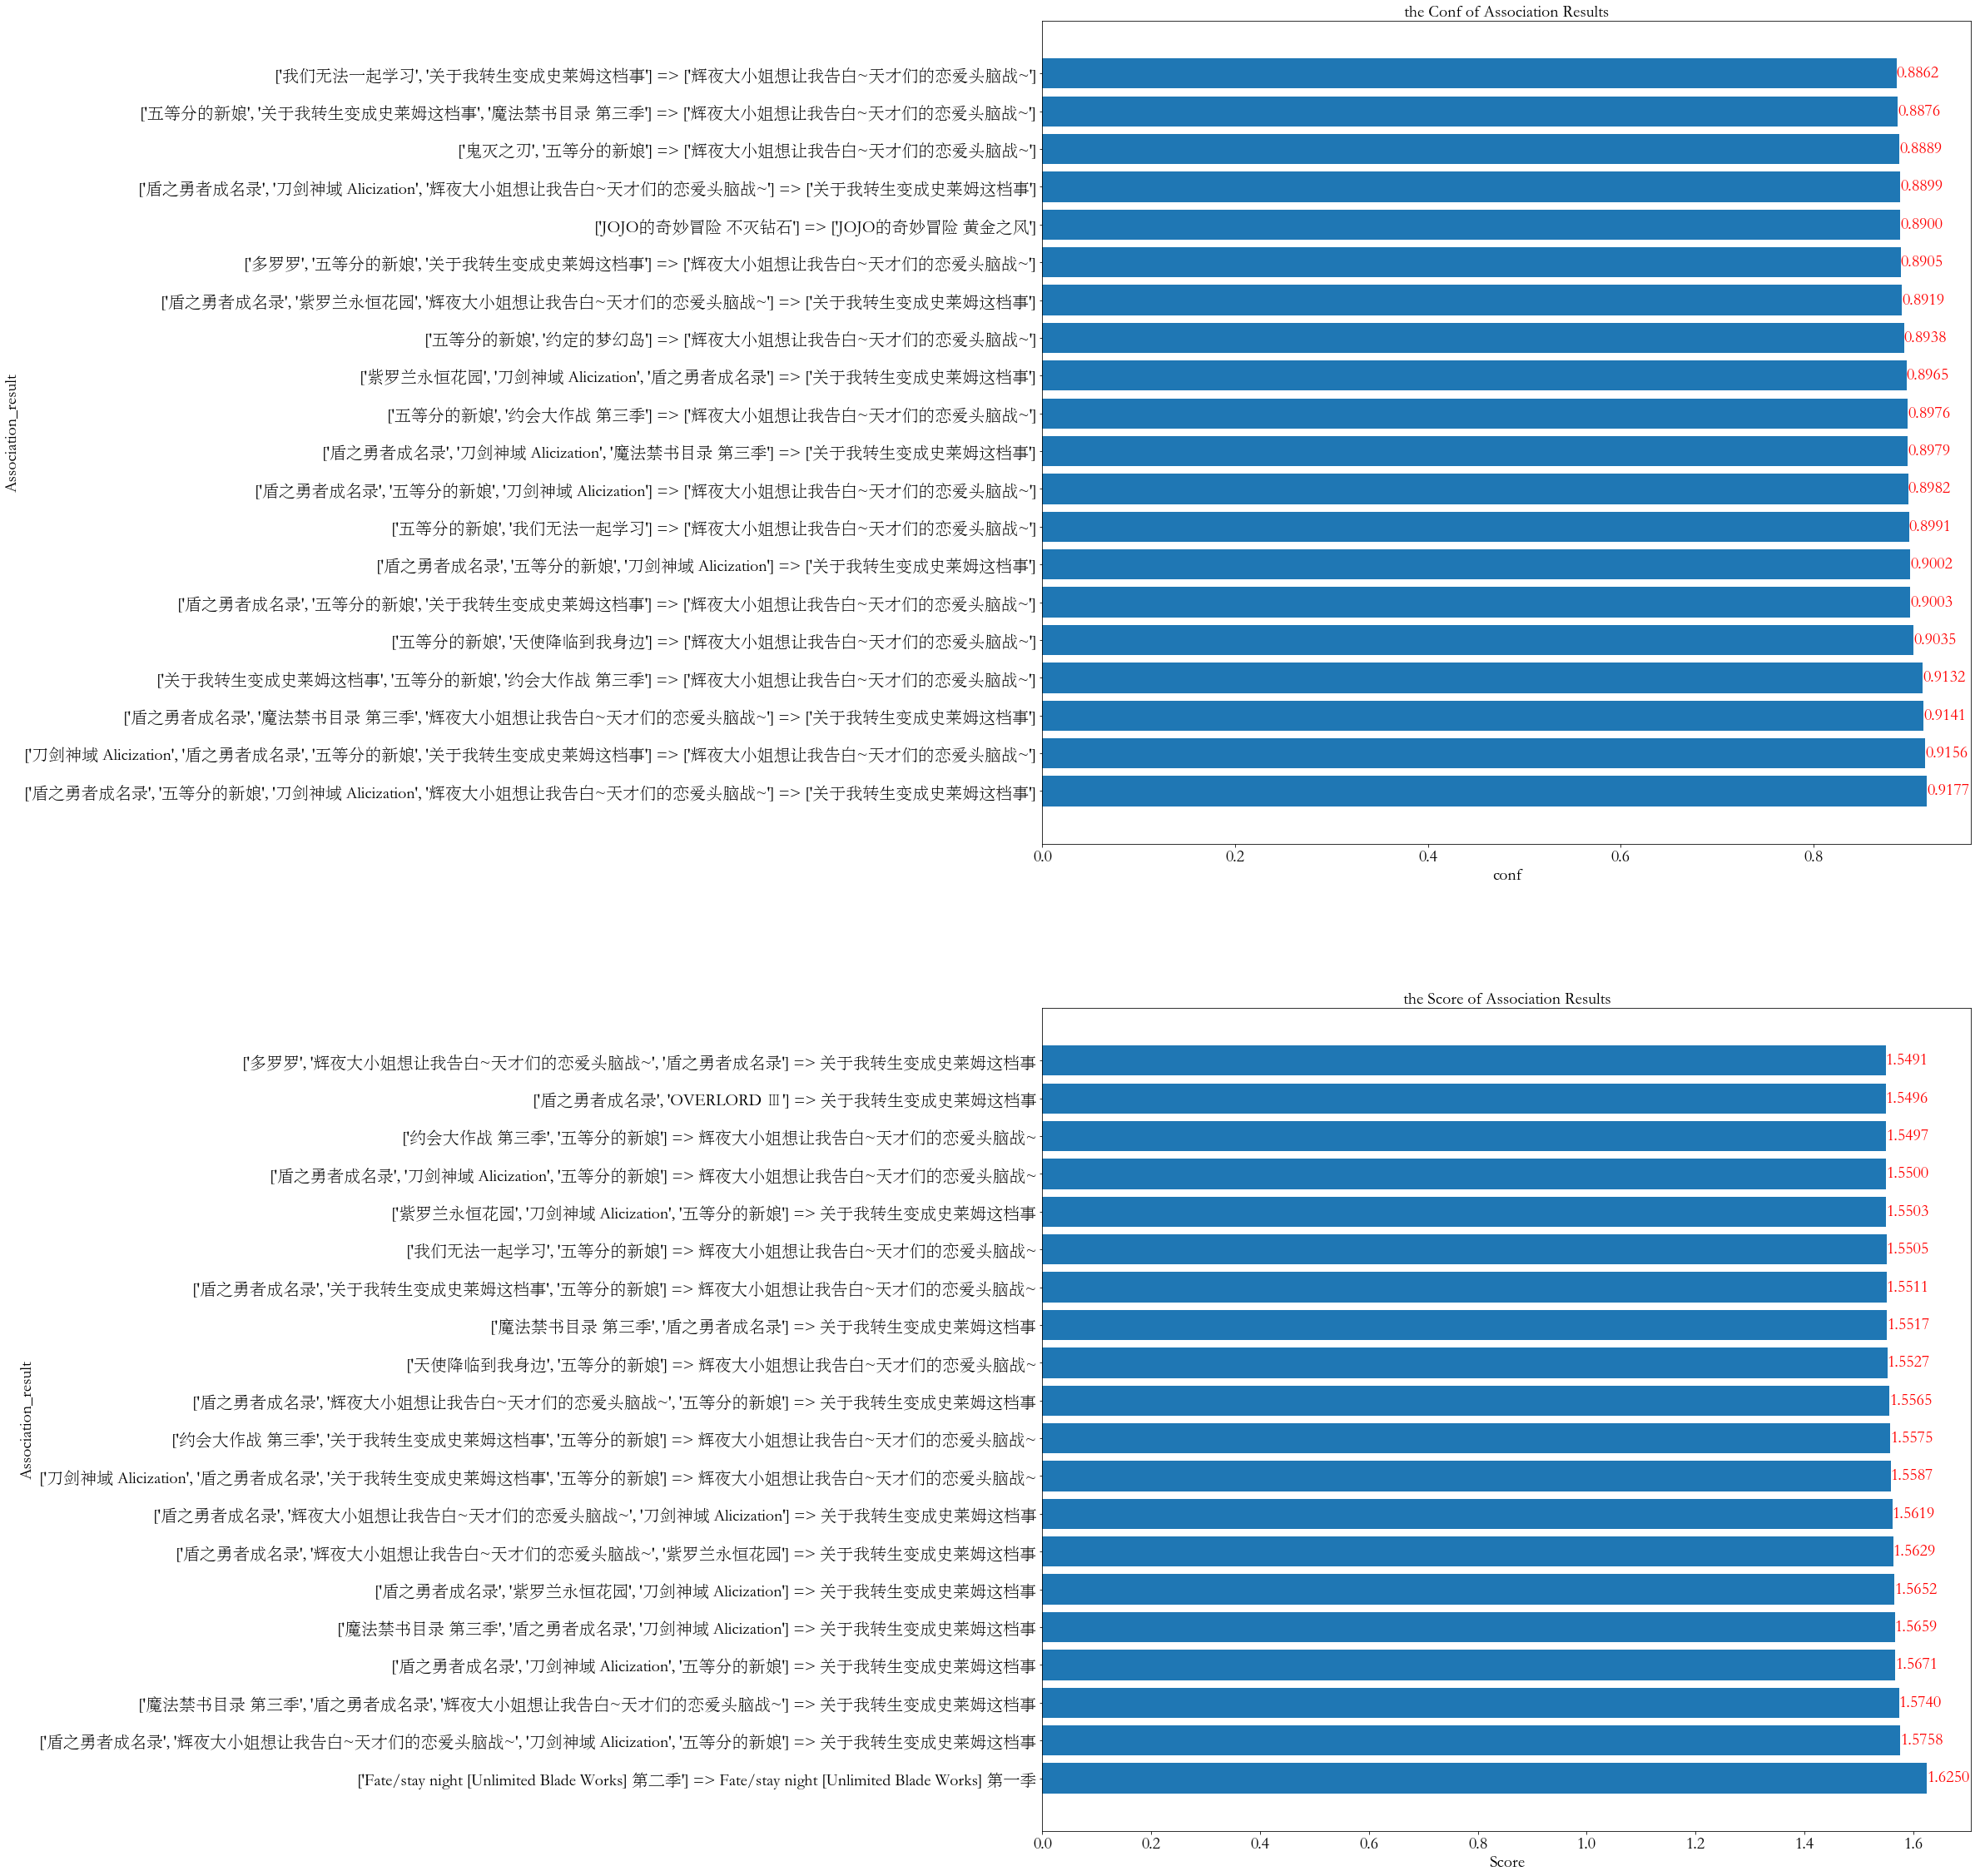

In [194]:
pl.rcParams['font.sans-serif'] = ['STSong'] # 指定默认字体
pl.rc
fig = plt.figure(figsize=(20,40)) 
plot1 = fig.add_subplot(2,1,1)

plot1.set_title('the Conf of Association Results',fontsize=20)
plot1.set_ylabel('Association_result',fontsize=20)
plot1.set_xlabel('conf',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
r = []
l = len(rules_sortedby_confidence)
for i in range(l):
    #s=str(list(rules_sortedby_confidence['rules_a'][i]))+' => '+str(list(rules_sortedby_confidence['rules_b'][i]))
    s=str(list(map(get_animation_title,list(rules_sortedby_confidence['rules_a'][i]))))+' => '+str(list(map(get_animation_title,list(rules_sortedby_confidence['rules_b'][i]))))
    r.append(s)
c = [conf for conf in rules_sortedby_confidence['confidence']]
# 关联规则表示出来很长，需要放在y轴上才能看清，所以用横向柱状图
plt.barh(r,c,align='center')
for a,b in zip(c,r):  
    plt.text(a, b, '%.4f' % a, ha='left', va= 'center',color='r',fontsize=20) 
    
plot2 = fig.add_subplot(2,1,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plot2.set_title('the Score of Association Results',fontsize=20)
plot2.set_ylabel('Association_result',fontsize=20)
plot2.set_xlabel('Score',fontsize=20)

r = []
l = len(rules_sortedby_score)
for i in range(l):
    s=str(list(map(get_animation_title,list(rules_sortedby_score['rules_a'][i]))))+' => '+get_animation_title(rules_sortedby_score['rules_b'][i])
    r.append(s)
c = [conf for conf in rules_sortedby_score['score']]
# 关联规则表示出来很长，需要放在y轴上才能看清，所以用横向柱状图
plt.barh(r,c,align='center')
for a,b in zip(c,r):  
    plt.text(a, b, '%.4f' % a, ha='left', va= 'center',color='r',fontsize=20) 

In [195]:
get_animation_title('6339')

'欢迎来到实力至上主义的教室'